In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/midterm

/content/drive/My Drive/midterm


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np
from matplotlib import pyplot as plt
from pytorchtools import EarlyStopping

from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 

from scipy.optimize import minimize
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#Regression
from sklearn.linear_model import LinearRegression, LogisticRegression
import pickle
from sklearn.externals import joblib

In [ ]:
# Dataset 불러들임
warnings.filterwarnings(action='ignore')

filename = '/content/drive/My Drive/midterm/train_data.csv'
data = pd.read_csv(filename)
data = data.fillna(data.mean())

# Data analysis


In [ ]:
#pd.options.display.max_rows=999
missing = data.isnull().sum()
#ST123CV, ST64CV, ST123TA, ST64TA is the missing feature data

count = data["DX_bl"].value_counts() #class 별 개수 
print(count, '\n\n')
print('Proportion:', round(count[0] / count[2], 2),':', round(count[1] / count[2], 2), ': 1')

1    814
0    485
2    308
Name: DX_bl, dtype: int64 


Proportion: 1.57 : 2.64 : 1


**1.** First of all, it was examined whether missing features exist in the data of Column E-BV and Column BW-EN. As a result, there were 847 missing features among 1607 subjects in **ST123CV, ST64CV, ST123TA and ST64TA.** (one missing features occured in ST24CV, ST44CV, ST24TA and ST44TA.) So, the missing features were filled with the mean of the feaure(column).

**2.** When comparing the number of data, the Mild cognitive impairment group was the largest with 814, the normal group was 485, and the AD group was 308. The MCI group, which is the median value between the normal group and the AD group, is the most common, and this data is imbalanced. The proportion between each data is **1.6: 2.6: 1**.



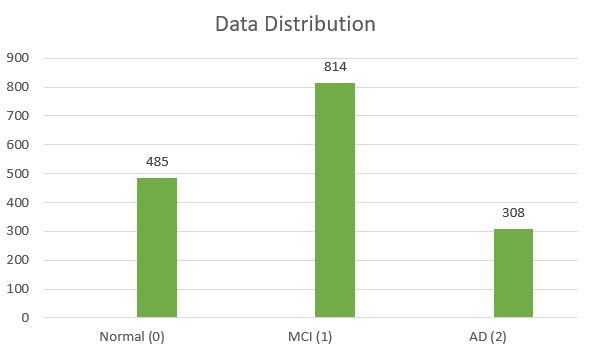

In [ ]:
data_1 = data.drop(["ADAS11","ADAS13","MMSE"],axis=1)
data_copy = data_1.copy()
#index 12, 48 featue is outlier

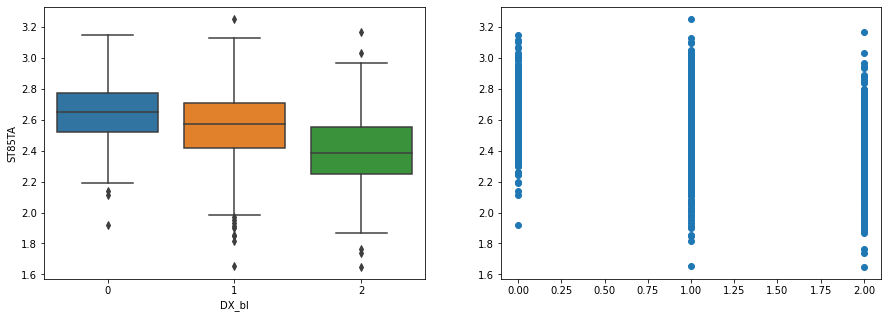

In [ ]:
# Normalized Data
df = data.drop(["DX_bl","ADAS11","ADAS13","MMSE"],axis=1)
data_norm = (df - df.mean())/df.std()

# Figure Box-plot
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(data["DX_bl"],data["ST85TA"],showfliers=True)
plt.subplot(122)
plt.scatter(data["DX_bl"],data["ST85TA"])

The above figure is a boxplot of one feature (ex: ST85TA). The middle line in the box represents the median, and the box represents the distribution from 25%(Q1) to 75%(Q3). The points outside the boxplot are outliers, and these are far from the distribution of the data. In fact, this data analysis reveals a lot of information while visualizing it, but it should not be assumed that it is an outlier because the brain volumes of subjects are all different.

If the distribution is good, the difference between the median values is large, and the boxes should not overlap by class, but these data overlap considerably and the median value also shows little difference. It is indicated that they are not suitable for learning. As I will mention repeatedly, the distribution of these data is a big problem.The outliers thought it could be a hindrance to learning, so through the code below, I dropped data that was 1.5 times the length of the box, 1.5 IQR.          



In [ ]:
# Remove outlier function
def remove_outlier(data, column, gr):
  
  Class = data[data["DX_bl"] == gr][column]
  q25 = np.percentile(Class, 25)
  q75 = np.percentile(Class, 75)

  iqr = (q75 - q25) * 1.5
  
  lowest = q25 - iqr
  highest = q75 + iqr
  outlier_index = Class[(Class < lowest) | (Class > highest) ].index.values

  return outlier_index.tolist()
  

In [ ]:
# Drop the outlier data
col_list = list(data_1.columns.values)[1:]
out0 = []
out1 = []
out2 = []

for j in range(3):
  temp = []
  print("//////class{}///////".format(j))
  for i in range(len(col_list)):
    out = remove_outlier(data_copy, col_list[i], j)
    temp.extend(out)

  cnt = Counter(temp)
  common = cnt.most_common(17)
  com_index = [word for word, word_count in common]
  
  if j == 0:
    out0.extend(com_index)
  elif j == 1:
    out1.extend(com_index)
  else :
    out2.extend(com_index)

  print(common)
  print(com_index)
#drop the outlier data that we wwant

#data_drop = data_copy.drop(out0, axis= 0)
data_drop = data_copy.drop(out1, axis= 0)
#data_drop = data_copy.drop(out2, axis= 0)


//////class0///////
[(1521, 36), (533, 26), (448, 24), (506, 20), (1304, 19), (578, 15), (845, 15), (1477, 14), (1190, 11), (1383, 10), (143, 10), (1363, 9), (303, 9), (1310, 9), (1443, 8), (1217, 8), (577, 8)]
[1521, 533, 448, 506, 1304, 578, 845, 1477, 1190, 1383, 143, 1363, 303, 1310, 1443, 1217, 577]
//////class1///////
[(1172, 38), (1031, 36), (335, 26), (737, 24), (907, 24), (1378, 23), (990, 22), (895, 22), (461, 20), (1048, 18), (987, 18), (1084, 18), (513, 17), (1472, 17), (1568, 16), (200, 15), (261, 15)]
[1172, 1031, 335, 737, 907, 1378, 990, 895, 461, 1048, 987, 1084, 513, 1472, 1568, 200, 261]
//////class2///////
[(528, 28), (1577, 22), (666, 19), (856, 18), (141, 14), (943, 12), (493, 11), (420, 11), (660, 10), (1226, 10), (332, 9), (1417, 9), (304, 9), (1139, 9), (898, 9), (1423, 8), (1462, 8)]
[528, 1577, 666, 856, 141, 943, 493, 420, 660, 1226, 332, 1417, 304, 1139, 898, 1423, 1462]


In [ ]:
# Correlation application
corr = data_1.corr(method = 'pearson')
aa = corr[corr['DX_bl']< -0.3].T
#aaa = correlation이 -0.3보다 큰 feature들의 label
aaa = aa.keys()
data_corr = data_copy[aaa]
data_corr2 = data_drop[aaa]


In [ ]:
def DecideXY(data):
  if data == 'drop_all':
    x = data_corr2.iloc[:,1:]
    y = data_drop['DX_bl']
  #only drop outlier data 
  elif data == 'drop_row':
    x = data_drop.iloc[:,1:]
    y = data_drop['DX_bl'] 
  #only drop uncorrelative feature
  elif data == 'drop_col':
    x = data_corr.iloc[:,1:]
    y = data_1['DX_bl'] 
  elif data == 'None':
    x = data_1.iloc[:,1:]
    y = data_1['DX_bl']
  
  return x, y

In [ ]:
x, y = DecideXY('None')

In [ ]:
# 10-fold Cross validation set
skf = StratifiedKFold(10,shuffle=True, random_state = 1)
train_index = list(range(0,len(aaa) * 10))
valid_index  = list(range(len(aaa) * 10,len(x)))
x_train_list = []
x_valid_list = []
y_train_list = []
y_valid_list = []
for train_index, valid_index in skf.split(x, y):
  x_train, x_valid = x.iloc[train_index, :].values, x.iloc[valid_index, :].values
  y_train, y_valid= y.iloc[train_index].values, y.iloc[valid_index].values
  x_train_list.append(x_train)
  x_valid_list.append(x_valid[:160,:])
  y_train_list.append(y_train)
  y_valid_list.append(y_valid[:160])
  

for x_valid in x_valid_list:
  print(x_valid.shape)

(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)
(160, 140)


**1.Drop the outlier data**    
We extracted 1.5*IQR data for each feature and listed the index and frequency of the data. The most extracted 17 data were designated as outlier and dropped. (The number of data dropped here is randomly designated during the experiment, so its meaning is not significant.)                
You can drop outliers of data of several classes, but there is a problem here. Data that is outlier in one class may have important information in another class. Therefore, it was not possible to drop all the outliers randomly, so only the data that appeared as outliers from many features were arbitrarily removed. And because the data of the MCI group is the largest and it is located between the normal and the AD group, so the outliers of the corresponding group were removed.

**2. Correlation between labels and features**    
The Pearson correlation coefficient is a quantification of the correlation between two variables. It has a value between +1 and -1, where +1 means a perfect positive linear correlation, 0 means no linear correlation, and -1 means a perfect negative linear correlation.             Although the size of the Pearson correlation coefficient is not absolute, it is usually considered to have a strong correlation if the size exceeds **0.3**.   
Features with positive correlation with label were not extracted, and there were **23 features** with strong negative correlation, and we tried to learn through them.

If we train with only 23 features, we can drop features that may be important for learning, so we tried learning with 38 features with a pearson correlation coefficient less than **0.25**.



---



In [ ]:
# Resampling Function 
def Resampling(x_train, y_train, sample):
  if sample == 'RandomUnderSampler':
    sampling = RandomUnderSampler(sampling_strategy='majority')
  elif sample == 'TomekLinks':
    sampling = TomekLinks(sampling_strategy='majority')
  elif sample == 'SMOTETomek':
    sampling = SMOTETomek()
  elif sample == 'RandomOverSampler':
    sampling = RandomOverSampler(sampling_strategy= 'minority')
  elif sample == 'SMOTE':
    sampling = SMOTE(sampling_strategy= 'minority')

  x_train_re, y_train_re = sampling.fit_sample(x_train, y_train)

  print(x_train_re.shape, y_train_re.shape)
  print(Counter(y_train_re))

  return x_train_re, y_train_re


**Resampling (Oversampling & Undersampling)**        
As seen in the boxplot graph above, the distribution of data according to labels tended to overlap too much. In addition, the MCI group has about twice as much data as other groups, so the data is imbalanced, which makes learning difficult. So, the data was augmented or corrected using various resampling techniques.



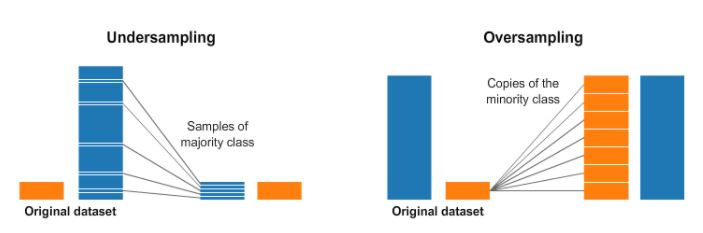

**1. Random Over/UnderSampling**    
It literally increases and decreases the number of data randomly. When Undersampling by label, the group with the largest data (MCI) was used, and when Oversampling, it was applied to the minority group (AD). Since the data is randomly increased and decreased, the learning accuracy is not constant in the current experiment where the total data is small, and there is a possibility of generating outliers.         
**2. TomekLinks**           
I thought TomekLinks was the best resampling strategy for the data we had. The distribution of our data is so overlapping that when we learn, most of our data is predicted by the MCI group, which is the majority and median data, so the learning accuracy tends to decrease. Tomeklinks are pairs of very close instances, but of opposite classes. By removing the data of the majority class from each pair, it widens the space between the two classes and facilitates on classification task.       
**3. SMOTE**      
SMOTE(Synthetic Minority Oversampling TEchnique) is to create synthesizing elements in minority groups based on existing data. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. However, when the points of this SMOTE oversampling selects an outlier, we create data that is not related to the distribution of the data.

We will compare the performance of resampling strategies through several classification models below and use the best one.


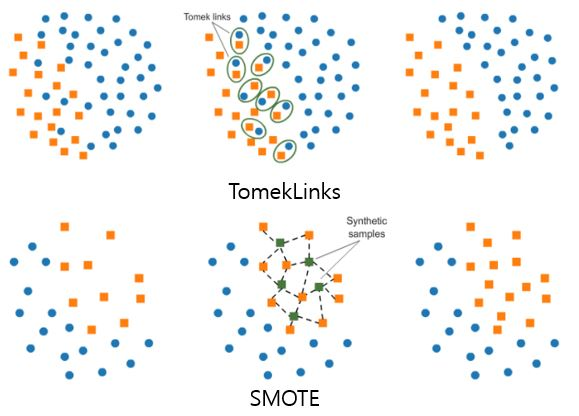

In [ ]:
#PCA analysis
def PCA_anal(x, n_comp):
  pca = PCA(n_components= n_comp)
  printcipalComponents = pca.fit_transform(x)
  
  return x

**PCA**          
PCA is a method of finding the principal components of data. However, PCA does not analyze the components of each data, but rather analyzes the principal components of this distribution when several data are collected to form a single distribution. In other words, it is a technique that converts samples from high-dimensional space into low-dimensional space by finding axes that are orthogonal to each other while preserving variance as much as possible. The principal component refers to the direction vector in which the variance of data is greatest in that direction.

'Explained Variance Ratio' refers to the variance ratio result of projection on the each principal component vector. When looking at the output of the variance ratio, 0.54819966, 0.0447017, 0.03638499 are obtained. This means that 55% of the variance in the original dataset lies on the first principal component axis, and about 4.5% lies on the second principal component axis. As a result of reducing the dimension of the data set by using 20 principal components, only about 72% of data is used, and 28% is lost.

# 1-1. MLP Model

In [ ]:
#Dataset
class getDataset(Dataset):

  def __init__(self, x, y):
    #Normalization
    mu = np.mean(x, axis = 0)
    std = np.std(x, axis = 0)
    x = (x - mu) / std
    
    self.x_train = torch.tensor(x, dtype= torch.float32)
    self.y_train = torch.tensor(y)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.x_train[idx], self.y_train[idx]


In [ ]:
#model
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    fc1 = nn.Linear(140, 140)
    fc2 = nn.Linear(23, 23)
    fc3 = nn.Linear(140, 3)
    fc4 = nn.Linear(140,23)
    fc5 = nn.Linear(23, 3)
    dropout = torch.nn.Dropout(p=0.2)
    self.KNlayer = nn.Sequential(fc1,
                                nn.ReLU(),
                                fc3,)
    
    self.KNlayer2 = nn.Sequential(fc2,
                                nn.ReLU(),
                                fc4 )
  def forward(self, x):
     output = self.KNlayer(x)
     #output = self.KNlayer2(x)
  
     return F.log_softmax(output)
  
def weight_init(m):
    if type(m) == nn.Linear:
      nn.init.kaiming_uniform_(m.weight)
      nn.init.constant_(m.bias, 0.01)


model = Net()


In [ ]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
#train 
num_epochs = 500
avg_val_acc = 0
avg_val_loss = 0
avg_val_list = []
train_batch = 128
valid_batch = 16
patience = 100  # early stopping patience

for i in range(10):
  print('//////class {0}/////////'.format(i))
  
  train_dataset = getDataset(x_train_list[i], y_train_list[i])
  validation_dataset = getDataset(x_valid_list[i], y_valid_list[i])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= train_batch, shuffle = True)
  val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size= valid_batch, shuffle = False)
  
  num_train =len(train_dataset)
  num_valid = len(validation_dataset)
  
  early_stopping = EarlyStopping(patience=patience, verbose=True)
  for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    running_correct = 0
    val_running_loss = 0
    val_running_correct = 0

    for train_x, train_y in train_loader: 
      output = model(train_x)
      loss = criterion(output, train_y)
      
      _, predict = torch.max(output, 1)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      total_loss += loss.item()
      running_correct += torch.sum(predict == train_y.data) 
    epoch_loss = total_loss / (num_train / train_batch)
    epoch_acc = running_correct.double() / num_train * 100
    
    #validation
    model.eval()
    with torch.no_grad():
      for val_x, val_y in val_loader:
        val_output = model(val_x)
        val_loss = criterion(val_output, val_y)
        _, val_predict = torch.max(val_output, 1)

        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_predict == val_y.data) 

      val_epoch_loss = val_running_loss / (num_valid / valid_batch)
      val_epoch_acc = val_running_correct.double() / num_valid * 100

    #early stopping
    '''
      if epoch >= 40:
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            avg_val_list.append(val_epoch_acc.float().tolist())
            avg_val_loss += val_epoch_loss
            avg_val_acc += val_epoch_acc
            break
    '''
    if ((epoch + 1) % 100 == 0):

      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
      print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))
      print("===================================================")

    if (epoch == (num_epochs - 1)):
      avg_val_list.append(val_epoch_acc.float().tolist())
      avg_val_loss += val_epoch_loss
      avg_val_acc += val_epoch_acc
  model.apply(weight_init)
avg_val_loss /= 10
avg_val_acc /= 10

print(avg_val_list)   
print("avg validation loss: {:.5f}, acc: {:5f}".format(avg_val_loss, avg_val_acc))
        

**Dataset setting & Estabilish model architecture**           
We made a simple classifier that predicts labels by learning based on multi-layer perceptron and softmax. The code was mainly implemented through the pytorch library. The dataset was converted to a normal distribution to make it the same as the 'Standardscaler()' function used in other models. Designing the model's architecture was very tricky process. Due to the  data is very small, if the layers are deeply stacked, it is difficult to learn and it requires a lot of computational cost. So, the model was composed of two layers, and nonlinearity was given by adding an activation function, ReLU function, between them.

**Experiments Result**       
When using various preprocessed datasets and performing 10-fold cross validation, the average accuracy was 51%. It might be thought that we've got the answer half right, but in fact, the MCI group accounts for about 50% of the entire dataset, so it's hardly learned. Even if all are predicted by the MCI group, there will be a probability of 50% or more. I tried training several times while adjusting various hyperparameters (batch size, learning rate, etc.), but did not get any meaningful results.

# 1-2. LIGHTGBM

In [ ]:
params = {
    "n_estimators" : 600,
    "num_leaves" : 64,
    "subsample" : 0.8,
    "colsample_bytree" : 0.7,
    "objective" : 'multiclass'
}
params2 = {
    "n_estimators" : 500,
    "learning_rate" : 0.3,
    "max_depth" : 10,
    "alpha" : 0
}

In [ ]:
models = []
best_iter = 0
_y_predict = np.zeros(x_train.shape[0])
pred_fold = 0


In [ ]:
skf = StratifiedKFold(10,shuffle=True, random_state =41)
acc_avg = 0
for train_index, valid_index in skf.split(x, y):
  x_train, x_valid = x.iloc[train_index, :], x.iloc[valid_index, :]
  y_train, y_valid= y.iloc[train_index], y.iloc[valid_index]
  
  
  #x_train, y_train = Resampling(x_train, y_train, 'SMOTE')
  x_train = PCA_anal(x_train, 20)

  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid)

  
  #model = XGBClassifier(**params2)
  model = LGBMClassifier(**params)
  model.fit(x_train, y_train, verbose=False)
  
  pred_fold += model.predict_proba(x_valid[:159])
  pred = np.argmax(pred_fold,axis=1)
  print('Prediction :', Counter(pred))
  print('True Value : ', Counter(y_valid))
  y_valid = y_valid[:159]
  
  
  accuracy = accuracy_score(y_valid,pred)
  acc_avg += accuracy
  precision = precision_score(y_valid,pred,average='micro')
  recall = recall_score(y_valid,pred,average='micro')
  mse = mean_squared_error(y_valid, pred)


  print('accuracy : %f' %(accuracy * 100))
  print('Mean squared error: ', mse)
  print('Precision: ', precision)
  print('Recall: ', recall)
  print("================================")

print('Average Accuracy :', (acc_avg / 10) * 100 )
print("The End") 

Prediction : Counter({1: 110, 0: 32, 2: 17})
True Value :  Counter({1: 81, 0: 49, 2: 31})
accuracy : 55.974843
Mean squared error:  0.4591194968553459
Precision:  0.559748427672956
Recall:  0.559748427672956
Prediction : Counter({1: 120, 2: 20, 0: 19})
True Value :  Counter({1: 81, 0: 49, 2: 31})
accuracy : 50.314465
Mean squared error:  0.5345911949685535
Precision:  0.5031446540880503
Recall:  0.5031446540880503
Prediction : Counter({1: 129, 0: 23, 2: 7})
True Value :  Counter({1: 81, 0: 49, 2: 31})
accuracy : 46.540881
Mean squared error:  0.6289308176100629
Precision:  0.46540880503144655
Recall:  0.46540880503144655
Prediction : Counter({1: 128, 0: 24, 2: 7})
True Value :  Counter({1: 82, 0: 49, 2: 30})
accuracy : 49.685535
Mean squared error:  0.6163522012578616
Precision:  0.4968553459119497
Recall:  0.4968553459119497
Prediction : Counter({1: 132, 0: 23, 2: 4})
True Value :  Counter({1: 82, 0: 49, 2: 30})
accuracy : 53.459119
Mean squared error:  0.559748427672956
Precision:  0

In [ ]:
save = pickle.dumps(model)
model2 = pickle.loads(save)
model2.predict(x_train[0:1])

joblib.dump(model2, 'cls_model.pkl') 

['cls_model.pkl']

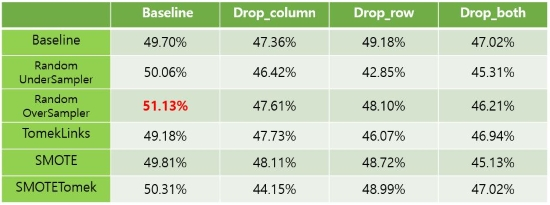

**Experiments Result**          
As a result of analyzing the data, the above table is a drop of data and features that are considered to be outlier or have a small correlation. It was predicted that removing outliers or features with little correlation would have more effect on classification task, but according to the experimental results, the baseline model performed best and the preprocessed dataset did not perform better than that.         

Also, various resampling strategies were applied. The undersampling and oversampling techniques were applied to the preprocessed data sets and compared the results. It is a value obtained by calculating the average of validation accuracies from 10-fold cross validation, and the accuracy was repeatedly measured several times. Before the experiment, since there was a lot of overlapping data, it was expected that TomekLinks resampling would show good performance, because it distinguishes the boundary, but overall most of the strategies did not show a big improvement.

It can be said that the above result was also practically not learned. The best average accuracy is 51%. When PCA analysis is used, it tends to improve by 1%, but there is no significant effect. We compared the number of predicted labels and actual labels by class. The actual label is evaluated according to the ratio using the StratifiedKFold() function, while the predicted label only shows the MCI, which is the majority group, as a predicted value.

**LightGBM**      
LightGBM is the Gradient Boosting framework and learning algorithm based on tree. LightGBM expands the tree vertically, while other algorithms expand horizontally. i.e. LightGBM is leaf-wise while other algorithms are level-wise. In this decision tree model, algorithms such as Xgboost and Randomforest also show good performance, but as a result of experiments, LightGBM has the fastest learning speed and good performance.




# 1-3. SVM

In [ ]:
skf = StratifiedKFold(10,shuffle=False, random_state =41)
pred_fold = 0
acc_avg = 0
for train_index, valid_index in skf.split(x, y):
  x_train, x_valid = x.iloc[train_index, :].values, x.iloc[valid_index, :].values
  y_train, y_valid= y.iloc[train_index].values, y.iloc[valid_index].values
  
  #x_train, y_train = Resampling(x_train, y_train, 'SMOTE')
  #x_train = PCA_anal(x_train, 20)

  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid)
  
  #PCA analysis
  pca = PCA(n_components=25)
  printcipalComponents = pca.fit_transform(x_train)
  

  estimator = LinearSVC()
  n_estimators = 100
  n_jobs = 2
  model = BaggingClassifier(base_estimator=estimator,
                          n_estimators=n_estimators,
                          max_samples=1./n_estimators,
                          n_jobs=n_jobs)
  model.fit(x_train,y_train)
  pred_fold += model.predict_proba(x_valid[:159])
  pred = np.argmax(pred_fold,axis=1)
  y_valid = y_valid[:159]
  accuracy = accuracy_score(y_valid,pred)
  acc_avg += accuracy
  print('Accuracy :',accuracy)
print('Average Accuracy :', ( acc_avg / 10) * 100)


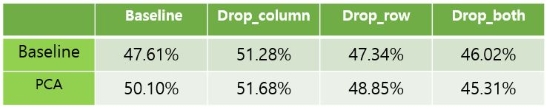

**SVM classification**       
Support Vector Machine (SVM) is an algorithm that is evaluated to perform much better than other machine learning algorithms. However, SVM has very high time/space complexity. To overcome this, a method of maintaining the SVM perfoemance and lowering the cost by using an ensemble technique has been proposed. 
Bagging is one of the ensemble techniques, which creates several small data sets by reconstruction extraction from training data, and creates a classifier with each data set. Then when we predict test label, we  uses a voting to decide class and label.

I tried using the support vector machine and the ensemble method, which are known to have good performance, but the results were not different from other models.

# 2-1. Linear Regression

In [ ]:
data_2 = data.iloc[:,:4]

x_reg = data_1.iloc[:,1:]
y_reg = data_2.iloc[:,1:]

MSE : 32.6418137687326
MSE : 27.00452968270636
MSE : 29.712508268292336
MSE : 32.879317150191426
MSE : 25.049620274896807
MSE : 24.8083195667836
MSE : 23.517832369142287
MSE : 28.523998886590245
MSE : 34.84505960991262
MSE : 25.123767456121744
Average MSE :  28.410676703337003


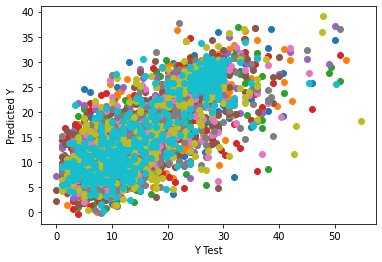

In [ ]:
kf = KFold(10,shuffle=True, random_state =1)
mse_avg = 0
for train_index, valid_index in kf.split(x_reg):
    x_train, x_valid = x_reg.iloc[train_index, :].values, x_reg.iloc[valid_index, :].values
    y_train, y_valid= y_reg.iloc[train_index].values, y_reg.iloc[valid_index].values

    scaler = StandardScaler()
    poly_Reg = PolynomialFeatures(degree=2, include_bias=True)
    # Fit on training set only.
    
    # Apply transform to both the training set and the test set.
    #x_train = poly_Reg.fit_transform(x_train)
    #x_valid = poly_Reg.fit_transform(x_valid)
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_valid = scaler.transform(x_valid) 
    

    model = LinearRegression()
    #model = LogisticRegression()

    model.fit(x_train,y_train)
    predictions = model.predict(x_valid)
    
    
    MSE = mean_squared_error(y_valid,predictions)
    print('MSE :', MSE)
    mse_avg += MSE
    plt.scatter(y_valid, predictions)
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    
print('Average MSE : ', (mse_avg / 10) )  

In [ ]:
save = pickle.dumps(model)
model2 = pickle.loads(save)
model2.predict(x_train[0:1])
model2
joblib.dump(model2, 'reg_model.pkl') 

['reg_model.pkl']

# 2-2. Neural Network Regression

In [ ]:
epoch = 500
learning_rate = 0.00003
batch_size = 64

In [ ]:
class AD_Prediction(nn.Module):
    def __init__(self):
        super(AD_Prediction, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Linear(140, 128),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 3) )                                  
                                    
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
    
        return out

    
def weight_init(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.01)

In [ ]:
model = AD_Prediction()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
kf = KFold(10,shuffle=True, random_state =41)

for train_index, valid_index in kf.split(x_reg):
  x_train, x_valid = x_reg.iloc[train_index, :].values, x_reg.iloc[valid_index, :].values
  y_train, y_valid= y_reg.iloc[train_index].values, y_reg.iloc[valid_index].values

  scaler = StandardScaler()
  # Fit on training set only.

  # Apply transform to both the training set and the test set.
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid) 

  train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle = True)
  train_loader_y = torch.utils.data.DataLoader(y_train, batch_size=batch_size, shuffle = True)

  val_loader = torch.utils.data.DataLoader(x_valid, batch_size=1, shuffle = False)
  val_loader_y = torch.utils.data.DataLoader(y_valid, batch_size=1, shuffle = False)
      

  list_train_loss = []
  list_valid_loss = []

  model.apply(weight_init)
  
  for i in range(epoch):            
      total_train_loss = 0
      total_valid_loss = 0
      
      #train
      for x, y in zip(train_loader, train_loader_y):
          x = x.float()
          y = y.float()
          output = model(x)
          loss = criterion(output, y)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          total_train_loss += loss.item()
          
      
      #validation
      model.eval()
      with torch.no_grad():
          for x, y in zip(val_loader, val_loader_y):
              x = x.float()
              y = y.float()
              val_output = model(x)
              val_loss = criterion(val_output, y)
  
              total_valid_loss += val_loss.item()

      if ((i + 1) % 10 == 0):
        print('Epoch',(i+1))
        print("training MSE loss: {:.5f}".format((total_train_loss / (len(x_train)/batch_size + 1))))
        print("validation MSE loss: {:.5f}".format((total_valid_loss / len(x_valid))))
        print("===================================================")
      
      list_train_loss.append(total_train_loss / (len(x_train)/batch_size + 1))
      list_valid_loss.append(total_valid_loss / len(x_valid))
  
  # plot epoch-loss function
  print("\n\n\n===================================================")
  print("===================================================")
  print("K-FOLD CHANGE")
  
  plt.plot(np.arange(0,epoch,1), np.array(list_train_loss),color='red')
  plt.plot(np.arange(0,epoch,1), np.array(list_valid_loss),color='blue')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  
  print("===================================================")
  print("===================================================\n\n\n")


# 2-3. K-NN Regression

In [ ]:
kf = KFold(10,shuffle=True, random_state =1)
mse_avg = 0
for train_index, valid_index in kf.split(x_reg):
  x_train, x_valid = x_reg.iloc[train_index, :].values, x_reg.iloc[valid_index, :].values
  y_train, y_valid= y_reg.iloc[train_index].values, y_reg.iloc[valid_index].values

  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid)

  regressor = KNeighborsRegressor(n_neighbors = 5, weights = "distance")
  regressor.fit(x_train, y_train)

  predictions = regressor.predict(x_valid)
    
  MSE = mean_squared_error(y_valid,predictions)
  print('MSE :', MSE)
  mse_avg += MSE
print('Average MSE : ', (mse_avg / 10) ) 

**Regression Results**         

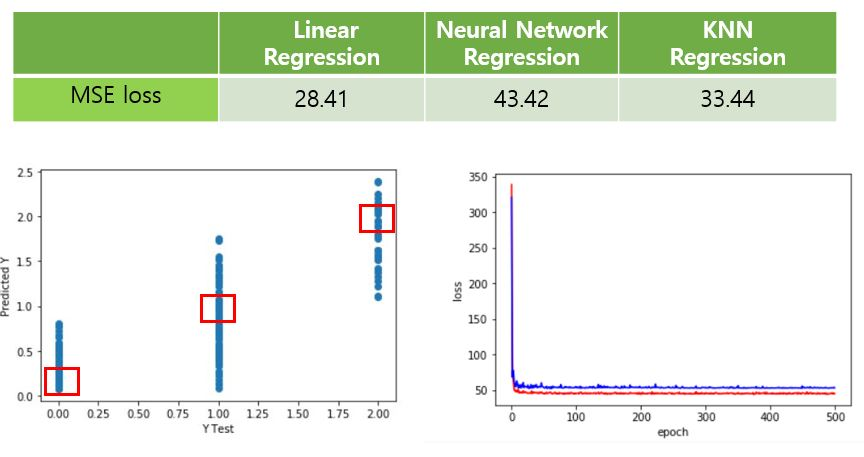


Unlike classification, regression is not a model that predicts one label. Regression is to model and predict the relationship between the dependent variable according to independent variables. From a machine learning perspective, the goal is to find the optimal weight parameter for each data and create a regression equation with the smallest error. Since we have to compare the three models, the error is **MSE loss**.        
The models in turn used polynomial, neural network, and K-NN models. It is the same as the learning process in classification, and only the result value is different by mse loss, so the analysis of the code will be omitted.  
        
Looking at the table above, the loss of linear regression is the smallest. Next, the loss differed in the order of knn regression model and neural network regression model. Looking at the complexity of the model, the more complex the model, the lower the performance. The data is not very big, so a simple model yielded better results.
Below, the first figure shows the distribution between the predicted labels and the actual labels.          
Below, the first figure shows the distribution between the predicted label and the actual label. It is normal when most of the data are distributed in the red box, but the predicted values are too sparse. The distribution of the MCI group (group 1) overlapped with the normal group (group 0) too much, so we learned and predicted incorrectly.         
The next graph figure, it shows the MSE loss per epoch in neural network regression. Looking at the graph, you can see that training did not overfit. Examining the two figures, the distribution of the data is a major factor to poor learning.

# Discussion

In this project, I used about 1600 subjects' cortical volume and average thickness of 70 brain regions as data to be learned. This dataset was an imbalanced dataset with more than 50% of the MCI groups. In addition, because the regional volume and thickness of the brain are different for each subject, the distribution in each group is also uneven and widely scattered. Since this data distribution is a factor that prevents proper learning, I focused on analyzing and preprocessing the data. The data preprocessing methods I used are ***Resampling (oversampling & undersampling), Removing outliers, and PCA and Pearson correlation methods***. In order to make predictions better, the data were processed in various ways, but as a result, the performance was not more noticeable than the baseline.

Then, we solved two tasks: classification and regression. We implemented three models per task and compared the performance of each. **MLP, LightGBM, and SVM models** were used for classification, and **linear regression, neural network, and K-NN** models were used for regression.Almost all 6 models did not train well, perhaps because I didn't extract meaningful data well in the preprocessing stage.         
Since it is medical data, I thought that recall is more important than accuracy, so I tried to find the recall rate in the Lightgbm model, which has relatively better performance, but this was also not good at about 53% on average.

I think we should consider a model that extracts the correlations and features well in data and classes.



